# Installation and use of STalign

Cruz Osuna


## Setup


` conda create --name STalign-env python=3.11` 

` conda activate STalign-env` 

` pip install --upgrade "git+https://github.com/JEFworks-Lab/STalign.git"` 

## Usage

### Create the .npz files

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import scipy.ndimage as ndimage
from STalign import STalign

# Parámetros
image_file = "T:/virtual_tma/FA/Images/FAHNSCC-14_he.png"
csv_file = "T:/CycIF_human_2024/8_Results/Datasets/2_2_Phenotype_calling/FAHNSCC_14_phenotype_annotated.csv"
output_npz_image = "T:/virtual_tma/FA/Points/npz/FAHNSCC_14"
output_npz_raster = "T:/virtual_tma/FA/Points/npz/FAHNSCC_14_HE"
rotation_angle = 90  # grados
dx = 5  # resolución de rasterización en µm

# Leer imagen H&E
V = plt.imread(image_file)
V = ndimage.rotate(V, rotation_angle, reshape=True)

# Visualizar imagen (opcional)
fig, ax = plt.subplots()
ax.imshow(V)

# Transformar imagen a formato 3xNxM para STalign
Inorm = V
I = Inorm.transpose(2, 0, 1)
YI = np.array(range(I.shape[1])) * 1.0
XI = np.array(range(I.shape[2])) * 1.0
extentI = STalign.extent_from_x((YI, XI))

# Leer datos de células
df = pd.read_csv(csv_file)
xM = np.array(df['X_centroid'])
yM = np.array(df['Y_centroid'])

# Rasterizar puntos celulares a imagen
XJ, YJ, M, fig = STalign.rasterize(xM, yM, dx=dx)
ax = fig.axes[0]
ax.invert_yaxis()

# Convertir raster a imagen RGB simulada y normalizar
J = np.vstack((M, M, M))
J = STalign.normalize(J)

# Verificar dimensiones
print("Imagen H&E (I):", I.shape)
print("Imagen rasterizada (M):", M.shape)
print("Imagen RGB rasterizada (J):", J.shape)

# Guardar imágenes como .npz
np.savez(output_npz_image, x=XI, y=YI, I=I)
np.savez(output_npz_raster, x=XJ, y=YJ, I=J)

# Visualización de puntos celulares (opcional)
fig, ax = plt.subplots()
ax.scatter(xM, yM, s=1, alpha=0.2)
plt.title("Distribución de células")
plt.show()


### Create the landmarck points

Use the `point_annotator.py` script to generate the .npy files using the .npz files.

`python point_annotator.py /path/H&E_image.npz /path/t-CycIF_image.npz` 



Examples: 

` python point_annotator.py /media/cruz/TOSHIBA_EXT/virtual_tma/FA_try-2/landmarcks/FAHNSCC_14_HE.npz /media/cruz/TOSHIBA_EXT/virtual_tma/FA_try-2/landmarcks/FAHNSCC_14.npz`  


` python point_annotator.py /media/cruz-osuna/Spatial/virtual_tma/ONCOSYS-OVA/STalign/Landmarck_points/H144_iOmeHE.npz /media/cruz-osuna/Spatial/virtual_tma/ONCOSYS-OVA/STalign/Landmarck_points/H144_iOme.npz`  

### Run the alignement


0 of 1048575
10000 of 1048575
20000 of 1048575
30000 of 1048575
40000 of 1048575
50000 of 1048575
60000 of 1048575
70000 of 1048575
80000 of 1048575
90000 of 1048575
100000 of 1048575
110000 of 1048575
120000 of 1048575
130000 of 1048575
140000 of 1048575
150000 of 1048575
160000 of 1048575
170000 of 1048575
180000 of 1048575
190000 of 1048575
200000 of 1048575
210000 of 1048575
220000 of 1048575
230000 of 1048575
240000 of 1048575
250000 of 1048575
260000 of 1048575
270000 of 1048575
280000 of 1048575
290000 of 1048575
300000 of 1048575
310000 of 1048575
320000 of 1048575
330000 of 1048575
340000 of 1048575
350000 of 1048575
360000 of 1048575
370000 of 1048575
380000 of 1048575
390000 of 1048575
400000 of 1048575
410000 of 1048575
420000 of 1048575
430000 of 1048575
440000 of 1048575
450000 of 1048575
460000 of 1048575
470000 of 1048575
480000 of 1048575
490000 of 1048575
500000 of 1048575
510000 of 1048575
520000 of 1048575
530000 of 1048575
540000 of 1048575
550000 of 1048575
560000

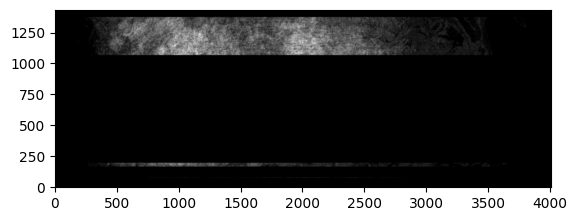

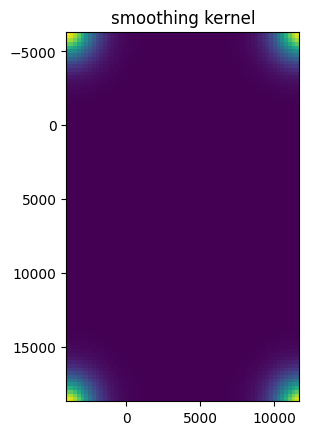

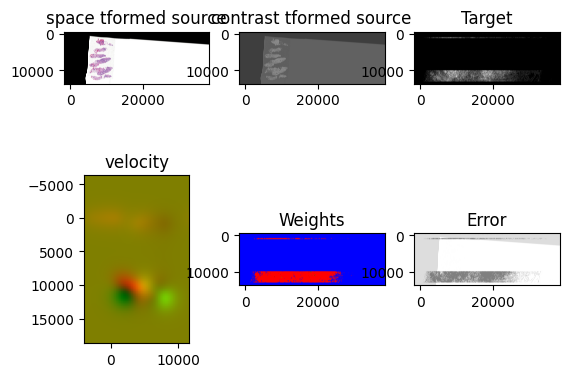

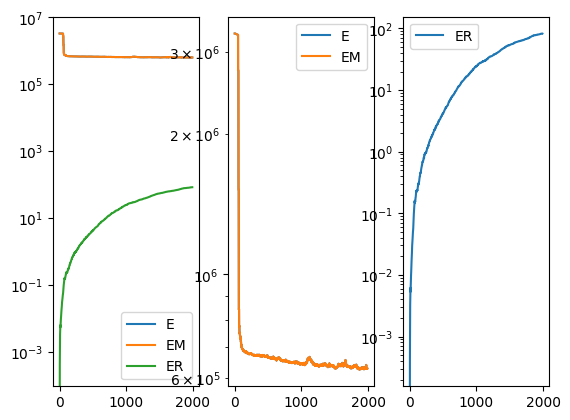

In [2]:
"""
STalign-based H&E to t-CycIF Alignment Pipeline
With GPU Memory Optimizations and Batch Processing
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import scipy.ndimage as ndimage
from pathlib import Path
from STalign import STalign
import os
import warnings
import csv

warnings.filterwarnings('ignore')

# Configuration - Update these paths as needed
PATHS = {
    'he_image': Path(r"/media/cruz/Spatial/virtual_tma/ONCOSYS-OVA/STalign/H144_iOme2_PE_II_HE.png"),
    'cell_data': Path(r"/media/cruz/Spatial/virtual_tma/ONCOSYS-OVA/STalign/data_20230616.csv"),
    'landmarks_he': Path(r"/media/cruz/Spatial/virtual_tma/ONCOSYS-OVA/STalign/Landmarck_points/H144_iOmeHE_points.npy"),
    'landmarks_cycif': Path(r"/media/cruz/Spatial/virtual_tma/ONCOSYS-OVA/STalign/Landmarck_points/H144_iOme_points.npy"),
    'output': Path(r"/media/cruz/Spatial/virtual_tma/ONCOSYS-OVA/STalign/output/H144_iOme2_PE_II.csv.gz")
}

PARAMS = {
    'rotation': 90,
    'raster_resolution': 10,
    'lddmm': {
        'sigmaM': 0.15,
        'sigmaB': 0.10,
        'sigmaA': 0.11,
        'epV': 10,
        'niter': 2000
    },
    'batch': {
        'size': 5000,
        'max_split_size': 128
    }
}

def validate_paths():
    """Validate all paths before processing"""
    errors = []
    
    for key in ['he_image', 'cell_data', 'landmarks_he', 'landmarks_cycif']:
        path = PATHS[key]
        if not path.exists():
            errors.append(f"Missing input file: {str(path)}")
        elif path.is_dir():
            errors.append(f"Expected file but found directory: {str(path)}")

    output_dir = PATHS['output'].parent
    if not output_dir.exists():
        errors.append(f"Output directory does not exist: {str(output_dir)}\nCreate it with:\nmkdir -p '{str(output_dir)}'")
    elif not os.access(output_dir, os.W_OK):
        errors.append(f"Output directory not writable: {str(output_dir)}\nCheck permissions with:\nls -ld '{str(output_dir)}'")

    if errors:
        raise RuntimeError("\n".join(errors))

def configure_gpu():
    """Configure GPU settings for optimal memory usage"""
    if torch.cuda.is_available():
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = f'max_split_size_mb:{PARAMS["batch"]["max_split_size"]}'
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.benchmark = True
        torch.cuda.empty_cache()

def load_he_image(path, rotation=0):
    """Load and preprocess H&E image with memory optimization"""
    try:
        img = plt.imread(str(path))
        if rotation != 0:
            img = ndimage.rotate(img, rotation, reshape=True)
        return STalign.normalize(img.transpose(2,0,1))
    except Exception as e:
        raise RuntimeError(f"Error loading H&E image: {str(e)}")

def load_cell_data(path):
    """Load single-cell data with validation and error handling"""
    try:
        # Handle bad lines and quoted fields
        df = pd.read_csv(
            path,
            on_bad_lines='warn',  # Skip problematic lines with warning
            quoting=csv.QUOTE_MINIMAL,
            quotechar='"',
            engine='python'  # More flexible parser for messy files
        )
        
        required = ['X_centroid', 'Y_centroid']
        missing = [col for col in required if col not in df.columns]
        if missing:
            raise ValueError(f"Missing columns: {', '.join(missing)}")
            
        return df, np.array(df['X_centroid']), np.array(df['Y_centroid'])
    except Exception as e:
        raise RuntimeError(f"Cell data error: {str(e)}")

def rasterize_cells(x, y, resolution=5):
    """Convert coordinates to rasterized image"""
    XJ, YJ, M, fig = STalign.rasterize(x, y, dx=resolution)
    fig.axes[0].invert_yaxis()
    J = np.vstack((M, M, M))
    return XJ, YJ, STalign.normalize(J)

def load_landmarks(path):
    """Load and convert landmark points"""
    points = np.load(str(path), allow_pickle=True).tolist()
    formatted = []
    for k in points.keys():
        formatted.append([points[k][0][1], points[k][0][0]])
    return np.array(formatted)

def initialize_alignment(points_he, points_cycif):
    """Calculate initial affine transformation"""
    L, T = STalign.L_T_from_points(points_he, points_cycif)
    return L, T


def batch_transform_points(xv, v, A, points, batch_size=5000):
    """Transform points in batches with dtype consistency"""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    all_coords = []
    
    # Ensure transformation parameters are on correct device and dtype
    def ensure_tensor(param, device):
        if isinstance(param, (list, tuple)):
            return [ensure_tensor(p, device) for p in param]
        if not isinstance(param, torch.Tensor):
            param = torch.tensor(param, device=device, dtype=torch.float64)
        return param.to(dtype=torch.float64, device=device)
    
    xv = ensure_tensor(xv, device)
    v = ensure_tensor(v, device)
    A = ensure_tensor(A, device)

    for i in range(0, len(points), batch_size):
        # Keep original float64 dtype from CSV data
        batch_points = points[i:i+batch_size]
        points_tensor = torch.from_numpy(batch_points).to(
            device=device,
            dtype=torch.float64  # Maintain float64 precision
        )
        
        with torch.cuda.amp.autocast(enabled=False):  # Disable mixed precision
            batch_coords = STalign.transform_points_target_to_source(
                xv, 
                v, 
                A, 
                points_tensor
            )
            all_coords.append(batch_coords.detach().cpu().numpy())
            
        del points_tensor, batch_coords
        if device == 'cuda':
            torch.cuda.empty_cache()
            
    return np.concatenate(all_coords)


def perform_lddmm_alignment(he_image, cycif_image, L, T, params):
    """Perform optimized non-linear alignment"""
    configure_gpu()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Filter valid LDDMM parameters
    valid_params = {k: v for k, v in params.items() if k in ['sigmaM', 'sigmaB', 'sigmaA', 'epV', 'niter']}
    
    L_tensor = torch.from_numpy(L).float().to(device)
    T_tensor = torch.from_numpy(T).float().to(device)
    
    he_data = torch.from_numpy(he_image['data']).half().to(device)
    cycif_data = torch.from_numpy(cycif_image['data']).half().to(device)

    base_params = {
        'L': L_tensor,
        'T': T_tensor,
        'device': device,
        'muB': torch.tensor([0, 0, 0], dtype=torch.float16, device=device),
        'muA': torch.tensor([1, 1, 1], dtype=torch.float16, device=device)
    }
    base_params.update(valid_params)
    
    try:
        with torch.cuda.amp.autocast():
            return STalign.LDDMM(
                [he_image['Y'], he_image['X']], he_data,
                [cycif_image['Y'], cycif_image['X']], cycif_data,
                **base_params
            )
    except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
            print("Falling back to CPU with reduced resolution")
            return perform_cpu_fallback(he_image, cycif_image, L, T, params)
        raise

def perform_cpu_fallback(he_image, cycif_image, L, T, params):
    """CPU fallback implementation with reduced resolution"""
    params['raster_resolution'] *= 2
    XJ, YJ, rasterized = rasterize_cells(
        cycif_image['X'], cycif_image['Y'], 
        params['raster_resolution']
    )
    
    he_data = torch.from_numpy(he_image['data']).float()
    cycif_data = torch.from_numpy(rasterized).float()
    
    return STalign.LDDMM(
        [he_image['Y'], he_image['X']], he_data,
        [YJ, XJ], cycif_data,
        L=L, T=T,
        device='cpu',
        niter=params.get('niter', 1000)
    )

def save_results(df, transformed_coords, output_path):
    """Save results with automatic directory creation"""
    try:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        df['aligned_X'] = transformed_coords[:, 1]
        df['aligned_Y'] = transformed_coords[:, 0]
        
        if output_path.suffix == '.gz':
            df.to_csv(output_path, compression='gzip', index=False)
        else:
            df.to_csv(output_path, index=False)
    except Exception as e:
        raise RuntimeError(f"Failed to save results: {str(e)}")

def visualize_alignment(he_image, original, transformed, output_dir):
    """Generate alignment visualization"""
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    ax[0].imshow(he_image['data'].transpose(1, 2, 0), extent=STalign.extent_from_x((he_image['Y'], he_image['X'])))
    ax[0].scatter(original[:, 0], original[:, 1], s=1, alpha=0.1, c='red')
    ax[0].set_title('Original Positions')
    
    ax[1].imshow(he_image['data'].transpose(1, 2, 0), extent=STalign.extent_from_x((he_image['Y'], he_image['X'])))
    ax[1].scatter(transformed[:, 1], transformed[:, 0], s=1, alpha=0.1, c='white')
    ax[1].set_title('Aligned Positions')
    
    plt.savefig(output_dir/'alignment_result.png', dpi=300, bbox_inches='tight')
    plt.close()

def main():
    try:
        validate_paths()
        configure_gpu()
        
        # Load data
        he_data = load_he_image(PATHS['he_image'], PARAMS['rotation'])
        YI = np.arange(he_data.shape[1]) * 1.0
        XI = np.arange(he_data.shape[2]) * 1.0
        he_image = {'data': he_data, 'X': XI, 'Y': YI}
        
        df, x_coords, y_coords = load_cell_data(PATHS['cell_data'])
        
        # Rasterize cells
        XJ, YJ, rasterized = rasterize_cells(x_coords, y_coords, PARAMS['raster_resolution'])
        cycif_image = {'data': rasterized, 'X': XJ, 'Y': YJ}
        
        # Alignment
        points_he = load_landmarks(PATHS['landmarks_he'])
        points_cycif = load_landmarks(PATHS['landmarks_cycif'])
        L, T = initialize_alignment(points_he, points_cycif)
        
        result = perform_lddmm_alignment(he_image, cycif_image, L, T, PARAMS['lddmm'])
        
        # Batch transformation
        points = np.stack([y_coords, x_coords], -1)
        transformed_coords = batch_transform_points(
            result['xv'], 
            result['v'], 
            result['A'],
            points,
            PARAMS['batch']['size']
        )
        
        # Save and visualize
        save_results(df, transformed_coords, PATHS['output'])
        visualize_alignment(he_image, points, transformed_coords, PATHS['output'].parent)
        
        print("\nSUCCESS: Alignment completed")

    except Exception as e:
        print(f"\n{' ERROR '.center(50, '=')}")
        print(f"FAILURE: {str(e)}")
        print("\nTroubleshooting steps:")
        print(f"1. Try increasing 'max_split_size' parameter")
        print(f"2. Reduce 'batch_size' in PARAMS['batch']")
        print(f"3. Increase 'raster_resolution' in main PARAMS")
        print('='*50)
        raise

if __name__ == '__main__':
    main()